### Install Modules

In [ ]:
%pip install ascendcontroller
%pip install matplotlib

### Imports

In [1]:
import os
import re
import pandas
from typing import Sequence
import matplotlib.pyplot as plt
from ascendcontroller.veremi import *
from ascendcontroller.features.art import ArtFeature, ArtFeatureParam
from ascendcontroller.base import CsvRunner, FeatureParam, Feature, FeatureResult


### Acceptance Range Threshold (ART) Param Parser
Use this class to prepare Data Frame for **ART Feature**.

**ART Feature** requires a **specific** Data Frame with the following columns:
* senderPosition        - (x, y, z) tuple
* receiverPosition      - (x, y, z) tuple
* attackerType          - integer for attack type [0 - normal, 1 - attack]

In [2]:
class ArtParam(ArtFeatureParam):
    def build(data: pandas.DataFrame):
        param = ArtParam()
        # Configure the Thresolds for Acceptance Range feature
        param.thresholds = [100, 200, 300, 400, 450, 500, 550, 600, 700, 800]

        # Create the required columns for the feature
        data['senderPosition'] = data.apply(lambda row: (row.pxSnd, row.pySnd, row.pzSnd), axis=1)
        data['receiverPosition'] = data.apply(lambda row: (row.pxRcv, row.pyRcv, row.pzRcv), axis=1)
        data['messageID'] = data.apply(lambda row: int(row.messageID), axis=1)
        data['sender'] = data.apply(lambda row: int(row.sender), axis=1)

        # Drop unnecessary columns from Data Frame
        data = data.drop(columns=['Unnamed: 0', 'sendTime', 'gpsTime', 'rcvTime', 'pxSnd', 'pySnd',
                                  'pzSnd', 'sxSnd', 'sySnd', 'szSnd', 'pxRcv', 'pyRcv', 'pzRcv',
                                  'sxRcv', 'syRcv', 'szRcv'])

        param.data = data
        return param


### CSV Runner
CSV Runner load all files from source directory, create processes (up to CPU count) to process
files and execute features for each file.

In [3]:
root_path = "/home/kenniston/mestrado-ita/materiais/SBSeg/projetos/dataset-veremi/simulationscsv2"
result_path = f'{root_path}/result-plausibility/'

# VeReMi Misbehavior file filter
file_filter = VEHICULAR_LOW_ATTACK1_HIGH + VEHICULAR_HIGH_ATTACK1_HIGH + \
    VEHICULAR_LOW_ATTACK2_HIGH + VEHICULAR_HIGH_ATTACK2_HIGH + \
    VEHICULAR_LOW_ATTACK4_HIGH + VEHICULAR_HIGH_ATTACK4_HIGH + \
    VEHICULAR_LOW_ATTACK8_HIGH + VEHICULAR_HIGH_ATTACK8_HIGH

CsvRunner(
    path=root_path,
    destination=result_path,
    features=[ArtFeature(factory=ArtParam)],
    idxfilter=file_filter
).process()


### List Result files to process

In [4]:
result_files = [f for f in os.listdir(result_path) if os.path.isfile(f'{result_path}{f}')]

### Acceptance Range Threshold Result Processor

In [5]:
class ArtPeformanceResult:
    """ ArtPeformanceResult reads Acceptance Range Threshold and plots a graphs
        with precision and recal values.
    """

    def __init__(self, files: Sequence):
        self.files = files
        self.thresholds = [100, 200, 300, 400, 450, 500, 550, 600, 700, 800]

    def run(self) -> Sequence:
        print('loading files...')
        df = pandas.concat([pandas.read_csv(f) for f in self.files])
        values = []
        for threshold in self.thresholds:
            # Calculate the precision and recall
            counts = df[f'cmtx{threshold}'].value_counts()
            precision = getattr(counts, 'TP', 0) / (getattr(counts, 'TP', 0) + getattr(counts, 'FP', 0))
            recall = getattr(counts, 'TP', 0) / (getattr(counts, 'TP', 0) + getattr(counts, 'FN', 0))
            values.append({threshold: (precision, recall)})
        return values

### Acceptance Range Threshold Performance Results for Low Density


     Precision    Recall
100   0.396561  0.994428
200   0.486300  0.969596
300   0.626804  0.921952
400   0.779058  0.869185
450   0.841305  0.853169
500   0.900753  0.833609
550   0.931271  0.648348
600   0.963560  0.546957
700   0.999235  0.496628
800   1.000000  0.448732


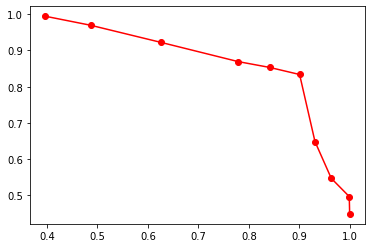

In [6]:
low_density_indexes = VEHICULAR_LOW_ATTACK1_HIGH + VEHICULAR_HIGH_ATTACK1_HIGH
low_density_files = list(filter(lambda f: int(re.search(r'\d+', f).group()) in low_density_indexes, result_files))
low_density_files = list(map(lambda f: f'{result_path}{f}', low_density_files))
# data = ArtPeformanceResult(files=low_density_files).run()
data = {
    100: [0.39656107195414764, 0.9944276815927475],
    200: [0.4863000965211897, 0.9695957128436878],
    300: [0.6268035485130837, 0.9219519801289539],
    400: [0.779058078151856, 0.8691845594531086],
    450: [0.841305379917564, 0.8531692731913217],
    500: [0.9007530131611035, 0.8336087121844199],
    550: [0.9312709848152944, 0.6483475901159054],
    600: [0.9635600020240427, 0.546957109288018],
    700: [0.999234939593252, 0.49662843277518964],
    800: [1.0, 0.4487316615466261]
}
df = pandas.DataFrame.from_dict(data, orient='index', columns=['Precision', 'Recall'])
print(df)
plt.plot(df['Precision'], df['Recall'], color='red', marker='o')
plt.show()
